
---

# Exercise 02: Bayesian Parameter Estimation via MCMC



# Importing


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
uploaded = files.upload()
from numpy import unravel_index
from termcolor import colored


Saving mcmc_cosmo_data.csv to mcmc_cosmo_data.csv


# Data loading

In [6]:
data= pd.read_csv('mcmc_cosmo_data.csv')
z = data['z']
D_L = data['D_L(Mpc)']
sigma_D = data['sigma_D(Mpc)']
data.head(20)

z     D_L(Mpc)  sigma_D(Mpc)
0   0.010000    53.092518            20
1   0.062105   275.738025            20
2   0.114211   543.648025            20
3   0.166316   829.223900            20
4   0.218421  1077.087212            20
5   0.270526  1374.126857            20
6   0.322632  1720.599828            20
7   0.374737  2026.914831            20
8   0.426842  2336.295625            20
9   0.478947  2701.494457            20
10  0.531053  3036.489913            20
11  0.583158  3401.079386            20
12  0.635263  3788.798188            20
13  0.687368  4127.638904            20
14  0.739474  4521.224291            20
15  0.791579  4941.697805            20
16  0.843684  5336.876548            20
17  0.895789  5774.175624            20
18  0.947895  6166.685573            20
19  1.000000  6579.411624            20

Extracting the redshift (z), luminosity distance (D_L), and their uncertainties (sigma_D) from the data file and converts them into NumPy arrays:

In [ ]:
z_obs_list = np.array(data['z'].tolist())
D_L_obs_list = np.array(data['D_L(Mpc)'].tolist())
sigma_D_list = np.array(data['sigma_D(Mpc)'].tolist())

Plotting a luminosity distance-redshift diagram:

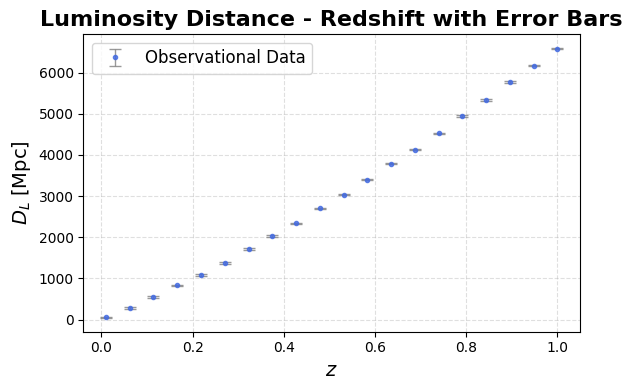

In [ ]:
plt.figure(figsize=(6, 4))
plt.errorbar(
    z_obs_list, D_L_obs_list, yerr=sigma_D_list,
    fmt='o', markersize=3, capsize=4,
    elinewidth=1, ecolor='gray', color='royalblue',
    alpha=0.8, label='Observational Data'
)

plt.xlabel('$z$', fontsize=14)
plt.ylabel('$D_L$ [Mpc]', fontsize=14)
plt.title('Luminosity Distance - Redshift with Error Bars', fontsize=16, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


 theory of luminosity distance for flat LCDM :


$$ D_L(z; H_0, \Omega_m) \approx \frac{c(1+z)}{H_0} \int_0^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3 + (1-\Omega_m)}} $$

where $c = 299{,}792.458\ \text{km/s}$. we will compute it this form:

In [ ]:
# Constants
c = 299792.458  # speed of light in km/s
H0 = 70         # Hubble constant in km/s/Mpc
Omega_m = 0.25   # matter density parameter

# Function inside the integral
def integrand(z, Omega_m):
    return 1.0 / np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

# Luminosity distance function from 0 to z
def luminosity_distance(z, H0, Omega_m):
    integral, _ = quad(integrand, 0., z, args=(Omega_m,), epsrel=1e-6)
    return (c * (1 + z) / H0) * integral

def D_L_theory_for_all_zs(z_obs_list, H0, Omega_m):
    return np.array([luminosity_distance(z, H0, Omega_m) for z in z_obs_list])

# 1. Model and Likelihood
- Assume Gaussian errors $\sigma_{D_L}$ for each data point.
- The likelihood for parameters $(H_0, \Omega_m)$ is:

$$ L(H_0, \Omega_m) \propto \exp\left( -\frac{1}{2} \sum_{i} \frac{\left[ D_{L,i}^{\text{obs}} - D_L(z_i; H_0, \Omega_m) \right]^2}{\sigma_{D_L}^2} \right) $$


In [ ]:
def log_likelihood(z_obs_list, H0, Omega_m, D_L_obs_list, sigma_D_list):
  D_L_model= D_L_theory_for_all_zs(z_obs_list, H0, Omega_m)
  # Gaussian log-likelihood
  main = D_L_obs_list - D_L_model
  var = sigma_D_list**2
  return -0.5 * np.sum((main**2)/var)

### 2. Set Prior Distributions as:
- $H_0 \sim \mathcal{U}(50,\, 90)$ km/s/Mpc  
- $\Omega_m \sim \mathcal{U}(0.1,\, 0.6)$

*Be careful! I will use log-prior!


In [ ]:
def prior(H0, omega_m):
  if 50 <= H0 <= 90 and 0.1 <= omega_m <= 0.6:
    return 0.0    # because log(1)=0
  return -np.inf  # because log(0)=-‚àû

Posterior ‚àù prior + likelihood ==>  log(prior)+ log(likelihood):



In [ ]:
def log_posterior(z_obs_list,D_L_obs_list, H0, Omega_m, sigma_D_list):
  pos= prior(H0, Omega_m)
  if not np.isfinite(pos):
       return -np.inf
  return pos + log_likelihood(z_obs_list, H0, Omega_m, D_L_obs_list, sigma_D_list)

### 3. Metropolis‚ÄìHastings Implementation
- Proposal: Gaussian jumps in both parameters:

$$ H_0^{\text{new}} \sim \mathcal{N}(H_0^{\text{old}}, \delta_{H_0}^2), \quad \Omega_m^{\text{new}} \sim \mathcal{N}(\Omega_m^{\text{old}}, \delta_{\Omega_m}^2) $$

- Compute acceptance ratio:

$$ r = \frac{P_{\text{posterior}}\left(H_0^{\text{new}}, \Omega_m^{\text{new}}\right)}{P_{\text{posterior}}\left(H_0^{\text{old}}, \Omega_m^{\text{old}}\right)} $$

- Accept or reject according to $u < r$, where $u \sim U(0,1)$:

In [ ]:
def run_Metropolis_Hastings(n_steps, initial, prop_std, z_obs_list, D_L_obs_list, sigma_D_list, thin=1, burn=0):
    # initial point: (H0, Om)
    H0_start, Om_start = initial
    log_posterior_start = log_posterior(z_obs_list, D_L_obs_list, H0_start, Om_start, sigma_D_list)
    samples = []
    n_accept = 0

    for i in range(n_steps):
        # propose
        H0_prop = np.random.normal(H0_start, prop_std[0])
        Om_prop = np.random.normal(Om_start, prop_std[1])
        log_posterior_prop = log_posterior(z_obs_list, D_L_obs_list, H0_prop, Om_prop, sigma_D_list)

           # acceptance (work in log-space)
        if not np.isfinite(log_posterior_prop):
            accept = False
        else:
            log_alpha = log_posterior_prop - log_posterior_start
            if log_alpha >= 0:
                accept = True
            else:
                u = np.log(np.random.rand())
                accept = (u < log_alpha)

        if accept:
            H0_start, Om_start = H0_prop, Om_prop
            log_posterior_start = log_posterior_prop
            n_accept += 1

        if i >= burn and ((i - burn) % thin == 0):
            samples.append((H0_start, Om_start))

    samples = np.array(samples)
    acc_rate = n_accept / n_steps
    return samples, acc_rate

RUN the algorithm:

In [ ]:
np.random.seed(42)

#  parameters
n_steps = 40000          # number of MH steps
initial = (70.0, 0.25)   # initial (H0, Omega_m)
prop_std = (0.5, 0.005)  # proposal stds for H0, Omega_m

#  run the Metropolis-Hastings
samples, acc_rate = run_Metropolis_Hastings(n_steps,initial,prop_std,z_obs_list,D_L_obs_list,sigma_D_list, thin=5, burn=5000)


print(colored("‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ", "cyan"))
print(colored("‚úÖ Metropolis‚ÄìHastings Results", "yellow", attrs=["bold"]))
print(colored("‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ", "cyan"))
print(colored(f"Acceptance rate: {acc_rate*100:.1f}%\n", "green"))


H0_samples = samples[:, 0]
Omega_m_samples = samples[:, 1]

#  posterior summaries
H0_med = np.median(H0_samples)
Om_med = np.median(Omega_m_samples)

H0_CI = np.percentile(H0_samples, [16, 84])
Om_CI = np.percentile(Omega_m_samples, [16, 84])

#  output
print(colored("üìè Parameter Estimates (Posterior Summary)", "magenta", attrs=["bold"]))
print(colored("‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ", "cyan"))

print(colored(f"H0 (Hubble constant):", "blue"),
      colored(f"{H0_med:.3f}  [ {H0_CI[0]:.2f} , {H0_CI[1]:.2f} ]", "white"))

print(colored(f"Œ©‚Çò (Matter density):", "blue"),
      colored(f"{Om_med:.4f}  [ {Om_CI[0]:.4f} , {Om_CI[1]:.4f} ]", "white"))

print(colored("‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ", "cyan"))


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚úÖ Metropolis‚ÄìHastings Results
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
Acceptance rate: 19.1%

üìè Parameter Estimates (Posterior Summary)
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
H0 (Hubble constant): 69.554  [ 69.12 , 70.00 ]
Œ©‚Çò (Matter density): 0.3185  [ 0.3054 , 0.3311 ]
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ


# Plotes :

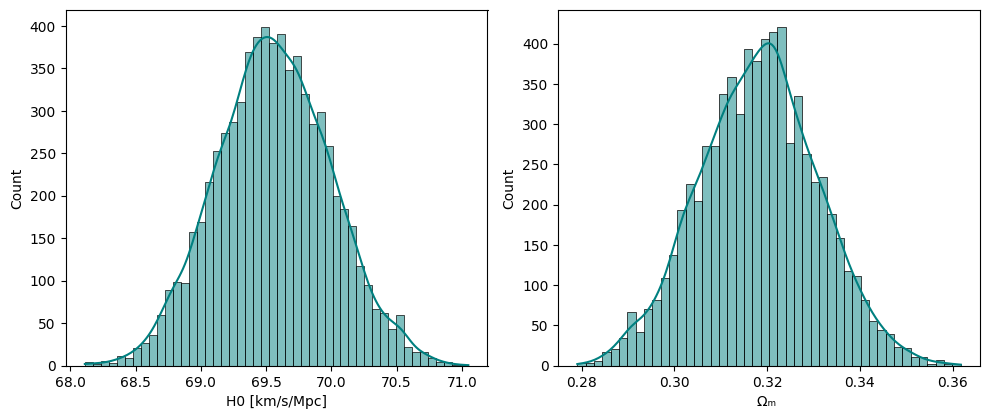

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
sns.histplot(H0_samples, kde=True, color='teal')
plt.xlabel('H0 [km/s/Mpc]')
plt.subplot(2,2,2)
sns.histplot(Omega_m_samples, kde=True, color='teal')
plt.xlabel('Œ©‚Çò ')
plt.tight_layout()
plt.show()


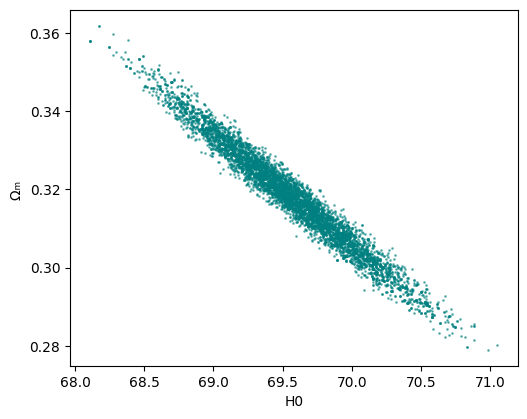

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,3)
plt.scatter(H0_samples, Omega_m_samples, s=1, alpha=0.5, color='teal')
plt.xlabel('H0'); plt.ylabel('Œ©‚Çò ')
plt.tight_layout()
plt.show()

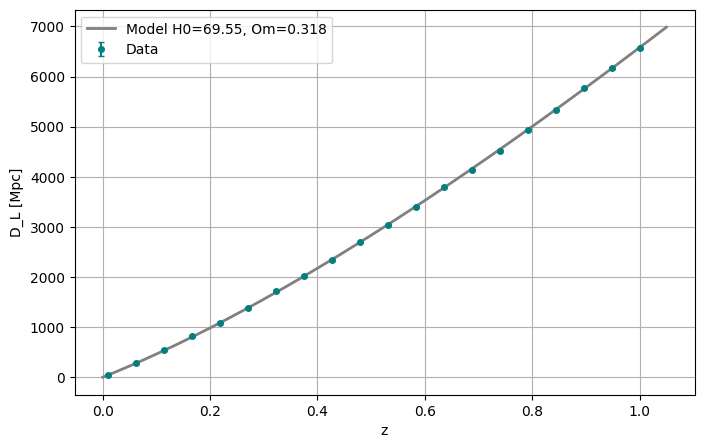

In [ ]:
# Compare best-fit (median) model with data
z_plot = np.linspace(0, max(z_obs_list)*1.05, 200)
D_model_plot = D_L_theory_for_all_zs(z_plot, H0_med, Om_med)

plt.figure(figsize=(8,5))
plt.errorbar(z_obs_list, D_L_obs_list, yerr=sigma_D_list, fmt='o', markersize=4, capsize=2, label='Data', color='teal')
plt.plot(z_plot, D_model_plot, label=f'Model H0={H0_med:.2f}, Om={Om_med:.3f}', lw=2, color='gray')
plt.xlabel('z'); plt.ylabel('D_L [Mpc]')
plt.legend(); plt.grid(True)
plt.show()

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.integrate import quad  # still needed once for theoretical D_L

torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cpu


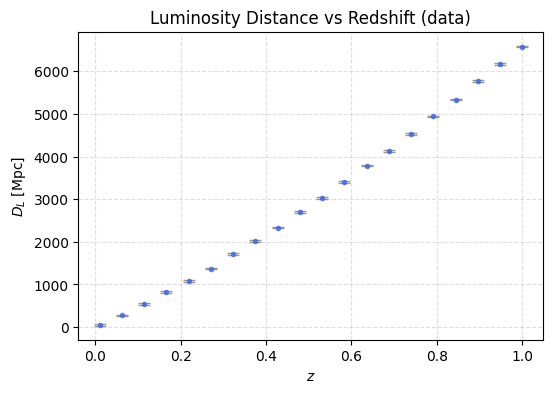

In [ ]:
data = pd.read_csv('mcmc_cosmo_data.csv')

# Clean NaNs
data = data.dropna(axis=1, how='all')
data = data.dropna(axis=0, how='all')

# Extract numpy arrays
z_obs = data['z'].values
D_L_obs = data['D_L(Mpc)'].values
sigma_D = data['sigma_D(Mpc)'].values

plt.figure(figsize=(6,4))
plt.errorbar(z_obs, D_L_obs, yerr=sigma_D, fmt='o', markersize=3,
             capsize=4, elinewidth=1, ecolor='gray', color='royalblue', alpha=0.8)
plt.xlabel('$z$'); plt.ylabel('$D_L$ [Mpc]')
plt.title('Luminosity Distance vs Redshift (data)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

In [ ]:
from scipy.integrate import quad

# constants
c = 299792.458  # km/s
def integrand(z, Omega_m):
    return 1.0 / np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

def luminosity_distance(z, H0, Omega_m):
    integral, _ = quad(integrand, 0., z, args=(Omega_m,), epsrel=1e-6)
    return (c * (1 + z) / H0) * integral

def D_L_theory_all(z_list, H0, Omega_m):
    return np.array([luminosity_distance(z, H0, Omega_m) for z in z_list])

# Convert to torch tensors for MCMC
z_torch = torch.tensor(z_obs, device=device)
D_L_obs_torch = torch.tensor(D_L_obs, device=device)
sigma_D_torch = torch.tensor(sigma_D, device=device)

In [ ]:
def log_likelihood_torch(H0, Om):
    # compute theoretical distances in numpy (no autograd)
    D_L_model_np = D_L_theory_all(z_obs, H0.item(), Om.item())
    D_L_model = torch.tensor(D_L_model_np, device=device)
    main = D_L_obs_torch - D_L_model
    var = sigma_D_torch ** 2
    return -0.5 * torch.sum((main ** 2) / var)

def log_prior_torch(H0, Om):
    cond = (50.0 <= H0 <= 90.0) and (0.1 <= Om <= 0.6)
    return torch.tensor(0.0 if cond else -torch.inf, device=device)

def log_posterior_torch(H0, Om):
    lp = log_prior_torch(H0, Om)
    if not torch.isfinite(lp):
        return torch.tensor(-torch.inf, device=device)
    return lp + log_likelihood_torch(H0, Om)

In [ ]:
def run_MH_torch(n_steps, initial, prop_std, thin=1, burn=0):
    H0_curr, Om_curr = [torch.tensor(v, device=device) for v in initial]
    log_post_curr = log_posterior_torch(H0_curr, Om_curr)
    samples = []
    n_accept = 0

    for i in range(n_steps):
        # propose new values
        H0_prop = torch.normal(H0_curr, prop_std[0])
        Om_prop = torch.normal(Om_curr, prop_std[1])
        log_post_prop = log_posterior_torch(H0_prop, Om_prop)

        if torch.isfinite(log_post_prop):
            log_alpha = log_post_prop - log_post_curr
            if (log_alpha >= 0) or (torch.log(torch.rand(1, device=device)) < log_alpha):
                H0_curr, Om_curr = H0_prop, Om_prop
                log_post_curr = log_post_prop
                n_accept += 1

        if i >= burn and ((i - burn) % thin == 0):
            samples.append([H0_curr.item(), Om_curr.item()])

    samples = np.array(samples)
    acc_rate = n_accept / n_steps
    return samples, acc_rate

In [ ]:
n_steps = 40000
initial = (70.0, 0.25)
prop_std = (0.5, 0.005)

samples, acc_rate = run_MH_torch(
    n_steps, initial, prop_std, thin=5, burn=5000
)

print("Acceptance rate:", round(acc_rate * 100, 2), "%")

H0_samples = samples[:,0]
Om_samples = samples[:,1]

H0_med = np.median(H0_samples)
Om_med = np.median(Om_samples)
H0_CI = np.percentile(H0_samples, [16,84])
Om_CI = np.percentile(Om_samples, [16,84])

print(f"H0 = {H0_med:.2f}  [{H0_CI[0]:.2f}, {H0_CI[1]:.2f}]")
print(f"Œ©_m = {Om_med:.3f}  [{Om_CI[0]:.3f}, {Om_CI[1]:.3f}]")


Acceptance rate: 18.7 %
H0 = 69.53  [69.11, 69.98]
Œ©_m = 0.319  [0.306, 0.332]


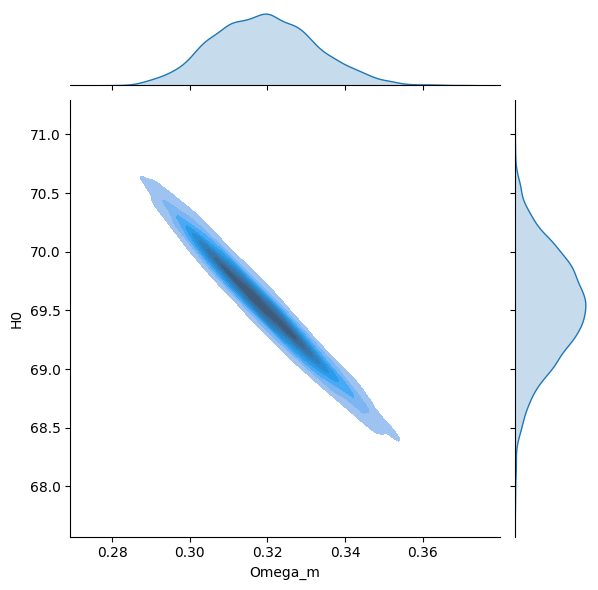

In [ ]:
import seaborn as sns
df = pd.DataFrame({'H0': H0_samples, 'Omega_m': Om_samples})
sns.jointplot(data=df, x='Omega_m', y='H0', kind='kde', fill=True)
plt.show()